# Experiment: Effect of Coupling Strength $h$

In this notebook we will look at how the coupling parameter $h$ effects the lyapunov spectrum and vectors of the two layer Lorenz 96 system.

In [1]:
# Standard Imports

import numpy as np
import random
import time as tm
import xarray as xr
import sys
import ipywidgets as widgets
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm 
from joblib import Parallel, delayed
import multiprocessing
import pickle

In [2]:
from ginelli_plot import *

## Reading Experiment Data

In [3]:
directory = '../Data'
h_experiment=[]
for i in tqdm(range(1, 6)):
    ds = xr.open_mfdataset(directory + f'/{i}/step5/*.nc', parallel=True, combine='by_coords', concat_dim='time')
    h_experiment.append(ds)

In [ ]:
h_noFf=[]
for i in tqdm([1,2,3,5]):
    ds = xr.open_mfdataset(f'h-test-noFf/{i}/step5/*.nc', parallel=True, combine='by_coords', concat_dim='time')
    h_noFf.append(ds)

## Plotting Spectra

Saving


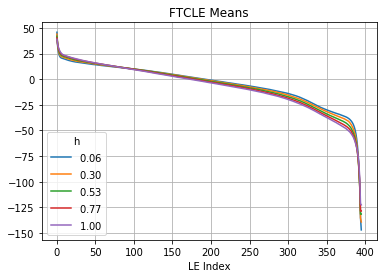

In [9]:
spectra_parameter(h_experiment, 'h', geometry='C', save = 'CLE-Spectra.png')

Saving


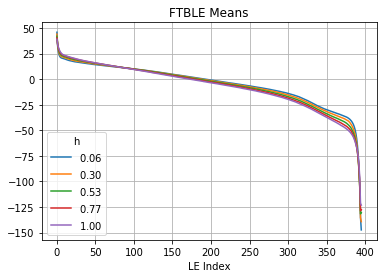

In [11]:
spectra_parameter(h_experiment, 'h', geometry='B', save = 'BLE-Spectra.png')

## Plotting Spectra Disagreement

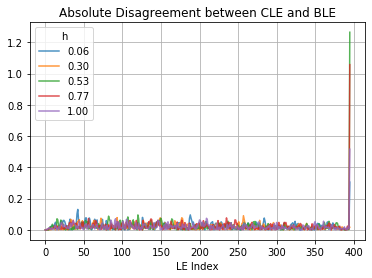

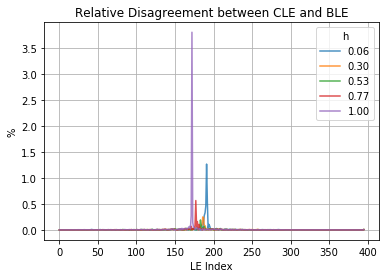

In [12]:
fig, ax = plt.subplots()
for data in tqdm(h_experiment):
    difference = np.abs(spectra(data, geometry='B') - spectra(data))
    ax.plot(difference, alpha = 0.8, label = f'{data.h:.2f}')
ax.set_title('Absolute Disagreement between CLE and BLE')
plt.legend(title = 'h')
ax.set_xlabel('LE Index')
plt.grid()
plt.savefig('LE-Disagreement-Abs.png', dpi=1200)
plt.show()

fig, ax = plt.subplots()
for data in tqdm(h_experiment):
    difference = np.abs(spectra(data, geometry='B') - spectra(data)).values
    les = spectra(data).values
    relative_error = [np.abs(diff/les[i]) for i, diff in enumerate(difference)]
    ax.plot(relative_error, alpha = 0.8, label = f'{data.h:.2f}')
ax.set_title('Relative Disagreement between CLE and BLE')
ax.set_xlabel('LE Index')
ax.set_ylabel('%')
plt.legend(title = 'h')
plt.grid()
plt.savefig('LE-Disagreement-Rel.png', dpi=1200)
plt.show()

## Determining $k_d$
$k_d$ is index of maximum positive lyapunov exponent.

In [7]:
for experiment in [h_experiment]:
    for data in tqdm(experiment):
        CLE = spectra(data)
        kd = min_pos(CLE)
        data.attrs.update({'k_d': kd})

When h=0.06, kd = 192
When h=0.30, kd = 188
When h=0.53, kd = 183
When h=0.77, kd = 178
When h=1.00, kd = 172


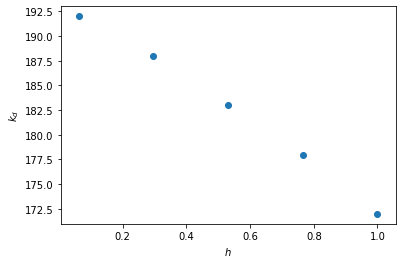

In [15]:
plt.scatter([data.h for data in experiment], [data.k_d for data in experiment])
plt.xlabel('$h$')
plt.ylabel('$k_d$')

for data in experiment: 
    print(f'When h={data.h:.2f}, kd = {data.k_d}')

## $k_d$ time Series

In [16]:
for data in h_experiment:
    print(f'Working on data with h={data.h}')
    
    b_kd_ts = []
    print('FTBLE Timeseries Loop')
    for ftble in tqdm(data.ftble):
        b_kd_ts.append(min_pos(ftble))
        
    c_kd_ts = []
    print('FTCLE Timeseries Loop')
    for ftcle in tqdm(data.ftcle):
        c_kd_ts.append(min_pos(ftcle))
        
    data['c_kd'] = xr.DataArray(np.array(c_kd_ts), dims=['time'], coords=[data.time], name='c_kd')
    data['b_kd'] = xr.DataArray(np.array(b_kd_ts), dims=['time'], coords=[data.time], name='b_kd')

Working on data with h=0.0625
FTBLE Timeseries Loop



FTCLE Timeseries Loop



Working on data with h=0.296875
FTBLE Timeseries Loop



FTCLE Timeseries Loop



Working on data with h=0.53125
FTBLE Timeseries Loop



FTCLE Timeseries Loop



Working on data with h=0.765625
FTBLE Timeseries Loop



FTCLE Timeseries Loop



Working on data with h=1.0
FTBLE Timeseries Loop



FTCLE Timeseries Loop


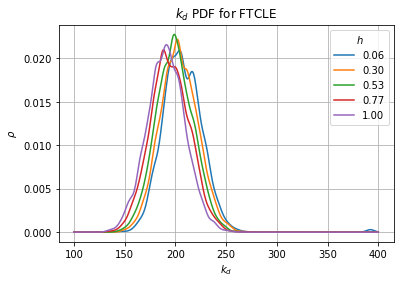

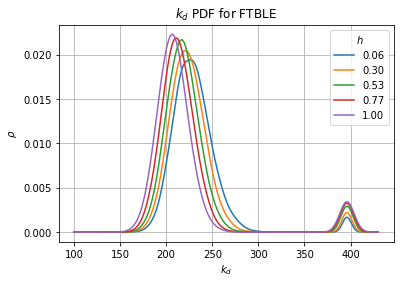

In [17]:
# kd Density Plots

fig, ax = plt.subplots()
for data in tqdm(h_experiment): #ftcle
    kd_ts = data.c_kd.values
    x_d = np.linspace(100, 400, 500) # Grid we evaluate PDF on
    kde = gaussian_kde(kd_ts) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
    pdf = kde.evaluate(x_d)
    ax.plot(x_d, pdf, label = f'{data.h:.2f}')
    
ax.set_title('$k_d$ PDF for FTCLE')
ax.set_xlabel('$k_d$')
ax.set_ylabel('$\\rho$')
ax.legend(title='$h$')
fig.show()
ax.grid()
fig.savefig('ckd-pdf.png', dpi=1200)


fig, ax = plt.subplots()
for data in tqdm(h_experiment): #ftble
    kd_ts = data.b_kd
    x_d = np.linspace(100, 430, 500) # Grid we evaluate PDF on
    kde = gaussian_kde(kd_ts) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
    pdf = kde.evaluate(x_d)
    plt.plot(x_d, pdf, label = f'{data.h:.2f}')

ax.set_title('$k_d$ PDF for FTBLE')
ax.set_xlabel('$k_d$')
ax.set_ylabel('$\\rho$')
ax.legend(title='$h$')
ax.grid()
fig.savefig('bkd-pdf.png', dpi=1200)

At some time points the final couple of ftbles are positive, this seems indicative of some kind of error. This does not appear in the ftcle.

FTBLE ERRORS
-----------------
When h = 0.06 for about 2.0% of time points do the ftble have some kind of error
When h = 0.30 for about 3.0% of time points do the ftble have some kind of error
When h = 0.53 for about 4.8% of time points do the ftble have some kind of error
When h = 0.77 for about 5.9% of time points do the ftble have some kind of error
When h = 1.00 for about 6.7% of time points do the ftble have some kind of error


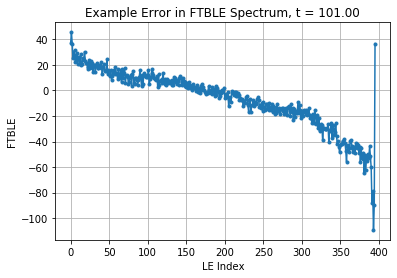

FTCLE ERRORS
-----------------
When h = 0.06 for about 0.3% of time points the ftcle have some kind of error
When h = 0.30 for about 0.0% of time points the ftcle have some kind of error
When h = 0.53 for about 0.0% of time points the ftcle have some kind of error
When h = 0.77 for about 0.0% of time points the ftcle have some kind of error
When h = 1.00 for about 0.0% of time points the ftcle have some kind of error


In [30]:
print('FTBLE ERRORS')
print('-----------------')
for data in h_experiment:
    times = data.time.values[data.b_kd.values >= 350]
    print(f'When h = {data.h:.2f} for about {len(times)/len(data.time) * 100:.1f}% of time points do'
          + ' the ftble have some kind of error')
plt.plot(data.ftble.sel(time = times)[5], '.-')
plt.title(f'Example Error in FTBLE Spectrum, t = {times[5]:.2f}')
plt.xlabel('LE Index')
plt.ylabel('FTBLE')
plt.grid()
plt.savefig('Example-Error.png', dpi=1200)
plt.show()

print('FTCLE ERRORS')
print('-----------------')

for data in h_experiment:
    times = data.time.values[data.c_kd.values >= 350]
    print(f'When h = {data.h:.2f} for about {len(times)/len(data.time) * 100:.1f}% of time points'
          + ' the ftcle have some kind of error')

## Correlations between FTLEs

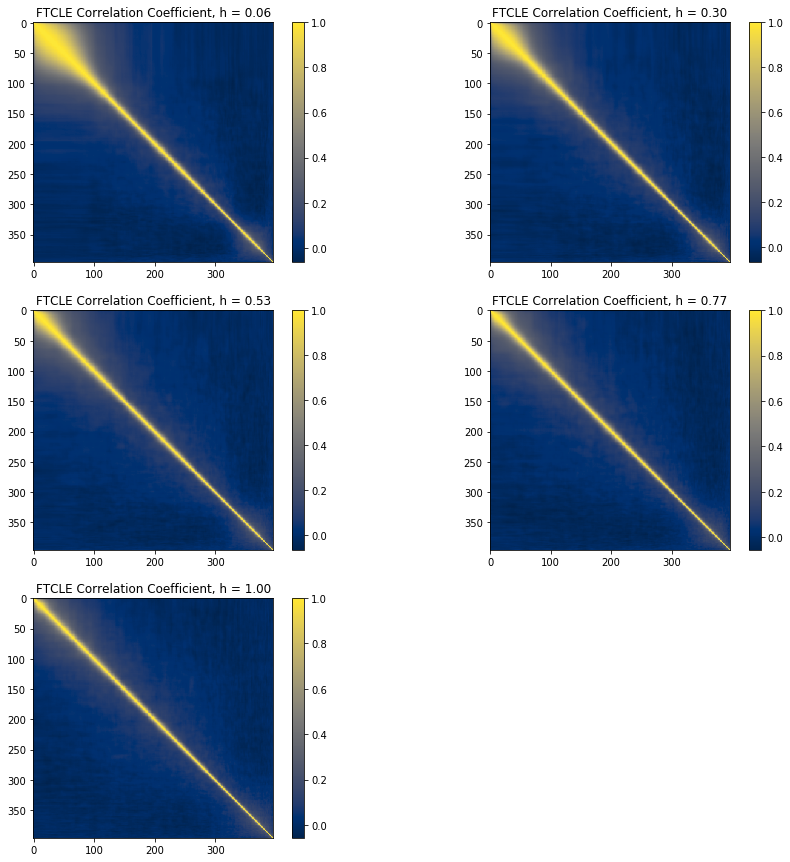

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))


for data, ax in zip(h_experiment, fig.axes):
    correlations = np.corrcoef(data.ftcle, rowvar=False)
    # Plot the heatmap
    im = ax.imshow(correlations, cmap = 'cividis')
    ax.set_title(f'FTCLE Correlation Coefficient, h = {data.h:.2f}')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
fig.delaxes(axes.flatten()[-1])
fig.savefig('FTCLE-Correlation.png', dpi=1200)
fig.show()

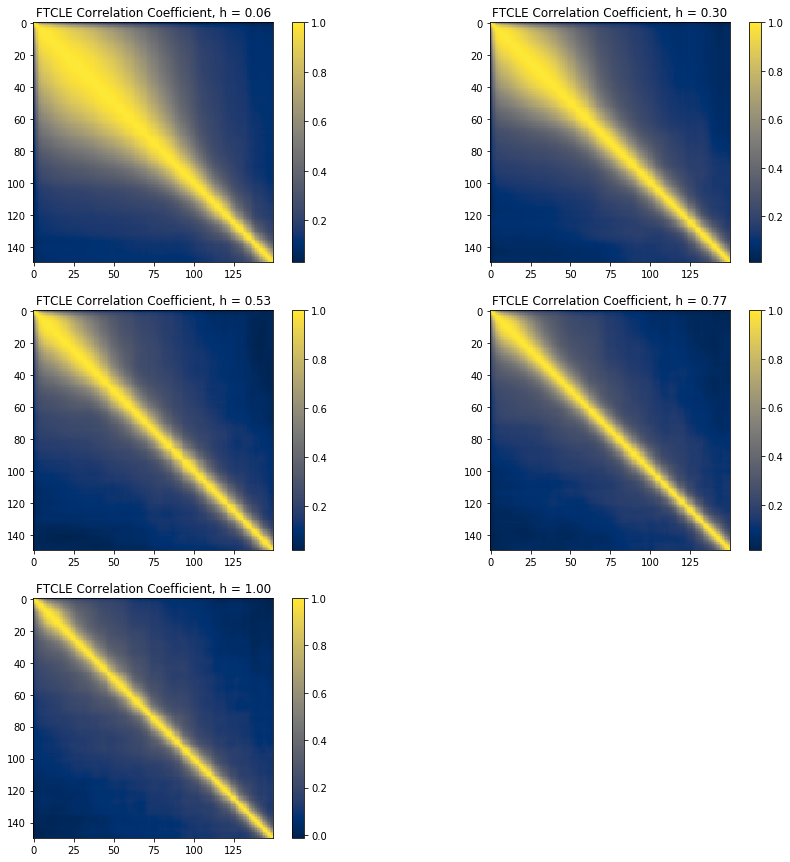

In [7]:
# Zoomed in plot
max_index = 150

fig, axes = plt.subplots(3, 2, figsize=(15, 15))


for data, ax in zip(h_experiment, fig.axes):
    ftle = data.ftcle.sel(le_index = np.arange(1, max_index + 1))
    correlations = np.corrcoef(ftle, rowvar=False)
    # Plot the heatmap
    im = ax.imshow(correlations, cmap = 'cividis')
    ax.set_title(f'FTCLE Correlation Coefficient, h = {data.h:.2f}')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
fig.delaxes(axes.flatten()[-1])
fig.savefig('FTCLE-Correlation-Zoom.png', dpi=1200)
fig.show()

# KS Entropy

In [ ]:
def ks_entropy()

## Angles
Code used for calculating and saving manifold angles is below. They should now just be loaded.

In [ ]:
from scipy.linalg import subspace_angles

In [ ]:
def manifold_angle(LV, kd):
    """Calculate angle between stable and unstable manifold for given CLVs i.e. max principle angle
    param, CLV, xarray of CLVs.
    param, kd, last positive le_index"""
    unstable_manifold = LV.sel(le_index = slice (LV.le_index.min().item(), kd) )
    stable_manifold = LV.sel(le_index = slice (kd + 1, LV.le_index.max().item()))
    return subspace_angles(unstable_manifold, stable_manifold)[0]

In [ ]:
def principle_angles(BLV, kd):
    """Calculate angle between stable and unstable manifold for given CLVs
    param, BLV, xarray of BLVs.
    param, kd, last positive le_index"""
    unstable_manifold = BLV.sel(le_index = slice (BLV.le_index.min().item(), kd) )
    stable_manifold = BLV.sel(le_index = slice (kd + 1, BLV.le_index.max().item()) )
    return subspace_angles(unstable_manifold, stable_manifold)

In [ ]:
for i in range(150, 160):
    for data in h_experiment:
        k_d = data.k_d
        plt.plot(np.rad2deg(principle_angles(data.CLV[i], 205)), '.-', label=f'h= {data.h:.2f}')
        plt.legend()
    plt.show()

In [ ]:
manifold_angles = []
     
for data in h_experiment:
    inputs = data.CLV 
    num_cores = multiprocessing.cpu_count()
    print(f'{num_cores} cores available.\n')
    print(f'Calculating angles for h = {data.h}\n')
    print(f'kd = {data.k_d}')

    angles = Parallel(n_jobs=num_cores)(delayed(manifold_angle)(CLV, data.k_d) for CLV in tqdm(inputs))
    manifold_angles.append(angles)

In [ ]:
# Calculating ALL principle angles
princ_angles = []
     
for data in h_experiment:
    inputs = data.CLV 
    num_cores = multiprocessing.cpu_count()
    print(f'{num_cores} cores available.\n')
    print(f'Calculating angles for h = {data.h}\n')
    print(f'kd = {data.k_d}')

    angles = Parallel(n_jobs=num_cores)(delayed(principle_angles)(CLV, data.k_d) for CLV in tqdm(inputs))
    princ_angles.append(angles)

In [ ]:
da = xr.open_dataset('h-effect/1/Min_Principle_Angle.nc')

In [ ]:
da.manifold_angle

In [ ]:
# Looking at dimension of tangency
for i, angles in enumerate(princ_angles):
    dim_intersect = []
    h = h_experiment[i].h
    print(h)
    for data in angles:
        dim_intersect.append(len(data[data <= 1.e-5]))
    plt.plot(h, dim_intersect.count(9), '*', label= f'{h}')
    print([[x, dim_intersect.count(x)] for x in set(dim_intersect)])
plt.legend()
plt.show()


In [ ]:
# # Saving
for i, angles in tqdm(enumerate(princ_angles)):
    print(f'h= {h_experiment[i].h}')
    print(len(angles[0]))
    _time = h_experiment[i].time.values
    pa_indexes = np.arange(len(angles[0]), 0, -1)
    print(xr.DataArray(angles, coords=[_time, pa_indexes], dims=['time','Angle_index'],  name='Principal_Angles'))
#                      attrs={'h': h_experiment[i].h}))
    print(f'Saving to h-effect/{i + 1}/Principle_Angle.nc')
    #da.to_netcdf(f'h-effect/{i + 1}/Manifold_Angle.nc')
    #h_experiment[i] = ds.assign({'Manifold_Angle':da})

In [ ]:
# # Saving
# for i, angles in tqdm(enumerate(manifold_angles)):
#     print(i)
#     da = xr.DataArray(angles, coords={'time':h_experiment[i].time.values}, dims='time', name='manifold_angle',
#                      attrs={'h':h_experiment[i].h})
#     print(f'Saving to h-effect/{i + 1}/Manifold_Angle.nc')
#     da.to_netcdf(f'h-effect/{i + 1}/Manifold_Angle.nc')
#     #h_experiment[i] = ds.assign({'Manifold_Angle':da})

### Loading Calculated Angles

In [ ]:
manifold_angles = []
for i in range(1, 6):
    ds = xr.open_dataset(f'h-effect/{i}/Manifold_Angle.nc')
    da = ds.manifold_angle
    manifold_angles.append(da)

### Angles Time Series Plot

In [ ]:
for i, data in enumerate(h_experiment):
    plt.plot(manifold_angles[i], label=f'h={data.h:.2f}')
plt.legend()
plt.show()

### Principal Angle Distribution

In [ ]:
for i, data in enumerate(h_experiment):
    angle = np.rad2deg(manifold_angles[i])
    x_d = np.linspace(min(angle) - 10, max(angle) + 10, 100) # Grid we evaluate PDF on
    kde = gaussian_kde(angle) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
    pdf = kde.evaluate(x_d)
    label = f'h = {data.h:.2f}'
    plt.plot(x_d, pdf, label = label)
plt.legend()
plt.title('Angle Between Positive and Negative CLV Space Denisty')
plt.xlabel('Angle ($^\\circ$)')
plt.ylabel('$\\rho$')
plt.show()

### Pairwise Angles

In [ ]:
import numpy.linalg as la

In [ ]:
def pair_theta(x, y):
    """"""
    dotprod_mat = np.dot(x,  y.T)
    costheta = dotprod_mat / la.norm(x, axis=1)[:, np.newaxis]
    costheta /= la.norm(y, axis=1)
    return np.arccos(costheta)

## Calculation of Minimum Angle Pairwise

In [ ]:
for i in range(0, 5):
    print(f'Working on {i}')
    for data in h_experiment:
        kd = data.k_d
        print(kd)
        min_angles = []
        for CLV in tqdm(data.CLV[::15]):
            unstable_manifold = CLV.sel(le_index = slice (CLV.le_index.min().item(), kd - i) ).T
            stable_manifold = CLV.sel(le_index = slice (kd + 1 + i, CLV.le_index.max().item()) ).T
            thetas = pair_theta(unstable_manifold, stable_manifold)
            theta = thetas.min()
            min_angles.append(theta)
        label = f'h = {data.h:.2f}'
        min_angles = np.rad2deg(min_angles)
        x_d = np.linspace(min(min_angles) - 10, max(min_angles) + 10, 100) # Grid we evaluate PDF on
        kde = gaussian_kde(min_angles) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
        pdf = kde.evaluate(x_d)
        plt.plot(x_d, pdf, label = label) 
    plt.legend()
    title = f'Pairwise Angle Between CLVs, Index Gap = {2 * i + 1}'
    plt.title(title)
    plt.xlabel('Angle ($^\\circ$)')
    plt.ylabel('$\\rho$')
    plt.savefig(f'Pairwise-Theta-Comparison{kd - i}-vs-{kd + 1 + i}.png', dpi=1200)
    plt.show()
    plt.figure()

In [ ]:
differences = []
for i in tqdm(range(len(spectra(data)) -  1 )):
    differences.append(spectra(data)[i] - spectra(data)[i +1])
plt.plot(differences)

In [ ]:
for data in tqdm(h_experiment):
    ranks(data.CLV[::100])

In [ ]:
CLV = data.CLV[0]

In [ ]:
np.linalg.matrix_rank(CLV)

In [ ]:
spectrum = spectra(data)
spectrum.sel(le_index= 10).values

In [ ]:
cut_points = range(10, 50)
cuts=[]
lens=[]
for c in cut_points:
    cuts.append(c)
    pa = principle_angles(CLV, c)
    pa[pa<0.1]
    lens.append(len(pa))

plt.plot(cuts, lens)
plt.show()

In [ ]:
cut_points = np.arange(250, 300)
ranks = [unstable_rank(CLV, c) for c in cut_points]
plt.plot(cut_points, ranks, '.')

In [ ]:
CLV = data.CLV[5000]
def unstable_rank(CLV, cut_point):
    unstable_manifold = CLV.sel(le_index = slice (CLV.le_index.min().item(), cut_point))
    return np.linalg.matrix_rank(unstable_manifold, tol= 1.e-16)

cut_points = np.arange(2, 396)
ranks = [unstable_rank(CLV, c) for c in cut_points]
plt.plot(cut_points, ranks, '.')
blank = np.linspace(2, 100, 100)
plt.plot(np.full_like(blank, 10), blank, '--', label = '$i = 10$', alpha = 0.5)
plt.plot(np.full_like(blank, data.k_d), blank, '--', label = '$i = k_d$', alpha = 0.5)
plt.legend()
plt.title('Rank of First $i$ Columns')
plt.xlabel('$i$')
plt.ylabel('Rank')
plt.savefig('Rank-With-Column.png', dpi=1200)
plt.show()
plt.plot(cut_points, np.gradient(ranks), '*', alpha=0.4)
blank = np.linspace(0, 1, 20)
plt.plot(np.full_like(blank, 10), blank, '--', label = '$i = 10$', alpha = 0.5)
plt.plot(np.full_like(blank, data.k_d), blank, '--', label = '$i = k_d$', alpha = 0.5)
plt.legend()
plt.title('Rate of Rank Increase')
plt.xlabel('$i$')
plt.ylabel('Gradient')
plt.savefig('Rate-of-Rank-Increase.png', dpi=1200)

In [ ]:
def neutral_rank(CLV, cut_point):
    neutral_manifold = CLV.sel(le_index = slice (10, cut_point))
    return np.linalg.matrix_rank(neutral_manifold)

cut_points = np.arange(50, 100)
ranks = [neutral_rank(CLV, c) for c in cut_points]
plt.scatter(cut_points, ranks)

In [ ]:
def stable_rank(CLV, cut_point):
    stable_manifold = CLV.sel(le_index = slice (cut_point, 396))
    return np.linalg.matrix_rank(stable_manifold)

cut_points = np.arange(50, 200)
ranks = [stable_rank(CLV, c) for c in cut_points]
plt.scatter(cut_points, ranks)

### Looking at Rank of Stable and Unstable Manifolds

In [ ]:
stable_ranks = [[] for i in range(5)]
#unstable_ranks = [[] for i in range(5)]

def ranks(CLV):
    unstable_manifold = CLV.sel(le_index = slice (CLV.le_index.min().item(), 60) )
    neutral_manifold = CLV.sel(le_index = slice(61, 204))
    stable_manifold = CLV.sel(le_index = slice (205, CLV.le_index.max().item()))
    unstable_rank = np.linalg.matrix_rank(unstable_manifold, tol = 1.e-8)
    neutral_rank = np.linalg.matrix_rank(neutral_manifold)
    stable_rank = np.linalg.matrix_rank(stable_manifold)

    return stable_rank#, neutral_rank, stable_rank
    
for i, data in enumerate(h_experiment):
    inputs = data.CLV[::100] 
    num_cores = multiprocessing.cpu_count()
    print(f'{num_cores} cores available.\n')

    stable_rank = Parallel(n_jobs=num_cores)(delayed(ranks)(CLV) for CLV in tqdm(inputs))
    #unstable_ranks[i].append(unstable_rank)
    stable_ranks[i].append(stable_rank)


  

In [ ]:
plt.plot(unstable_ranks[0][0])

In [ ]:
#stable_rank_means = [np.mean(ranks) for ranks in stable_ranks]
unstable_rank_means = [np.mean(ranks) for ranks in unstable_ranks]

In [ ]:
plt.plot(unstable_rank_means, '*')

In [ ]:
plt.plot(unstable_rank_means, '*')

In [ ]:
spectra(h_experiment[-1])

# Rate Functions

Code for analysis of rate functions. We look at:
 - Convergence of the rate functions for all coupling strengths

## Effect of Averaging Time on Rate Functions

Code used to check rate function convergence. 

We used $100$ random samples of FTCLEs to generate the plots. We computed the rate function of the FTCLE for an increasing averaging time.



In [4]:
# Takes time series of ftcle and caculates new time series for for longer averaging time
def ftcle_calculator(cle, L):
    return cle.rolling(time = L).mean()[L - 1::L]

In [29]:
# Calculates time unit for plots in 1/LE_1
def time_unit(data):
    return spectra(data).sel(le_index=1).values

Working on plots for h = 0.06

Directory  ../Plots/Rate-Function-Convergence/h0_06  already exists


Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_1.png


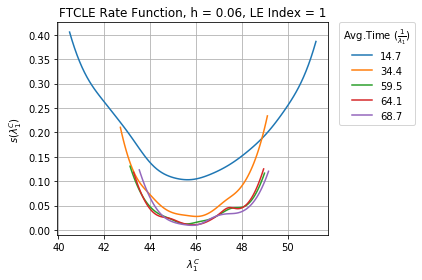

Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_2.png


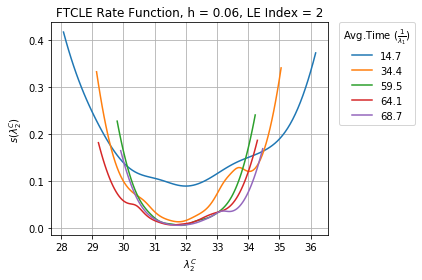

Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_3.png


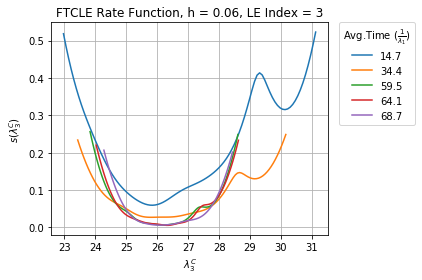

Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_191.png


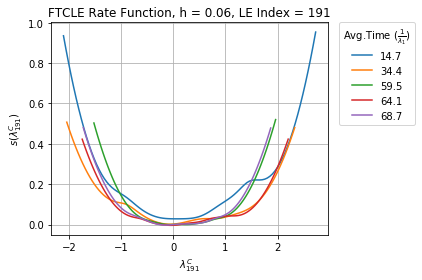

Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_192.png


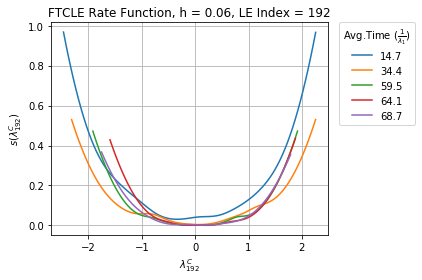

Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_193.png


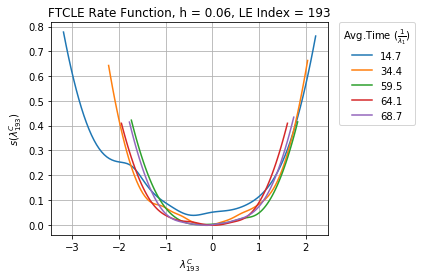

Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_374.png


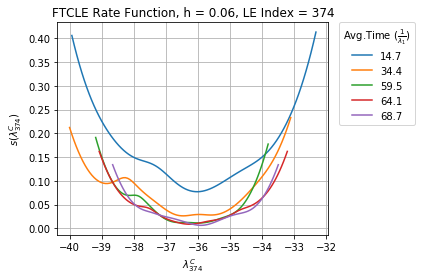

Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_375.png


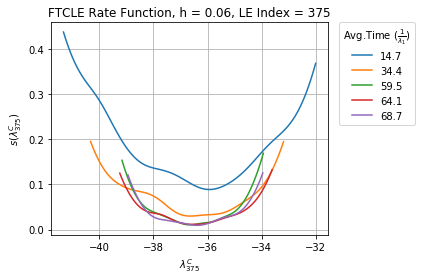

Will save at ../Plots/Rate-Function-Convergence/h0_06/LE_Index_376.png


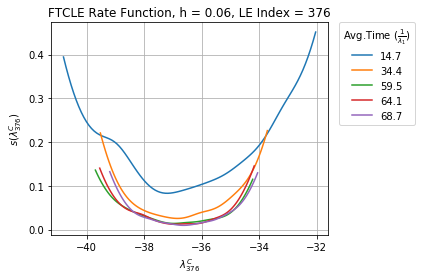


Working on plots for h = 0.30

Directory  ../Plots/Rate-Function-Convergence/h0_30  already exists


Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_1.png


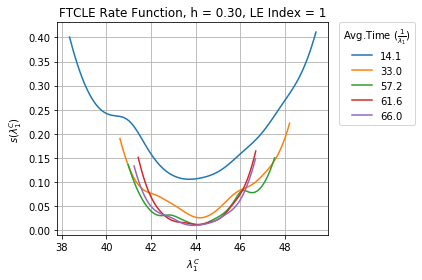

Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_2.png


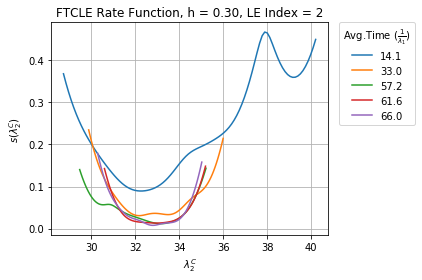

Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_3.png


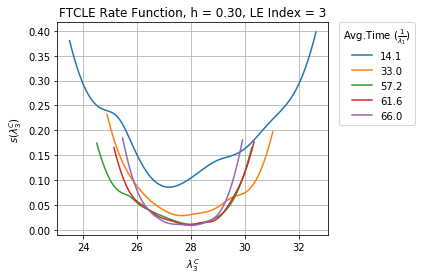

Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_187.png


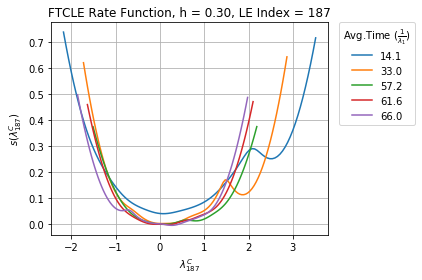

Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_188.png


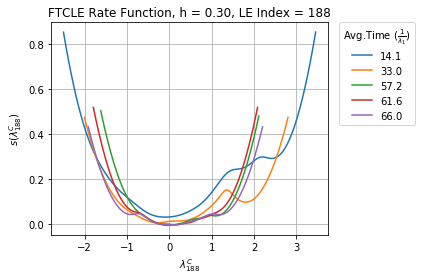

Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_189.png


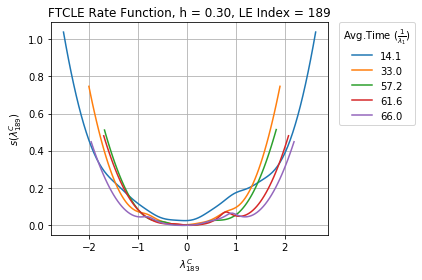

Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_374.png


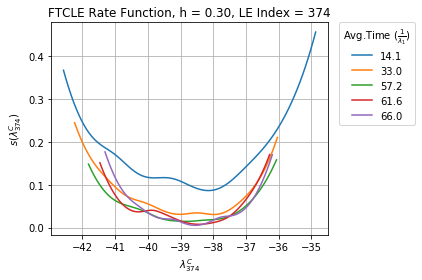

Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_375.png


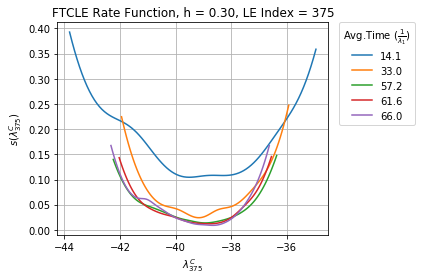

Will save at ../Plots/Rate-Function-Convergence/h0_30/LE_Index_376.png


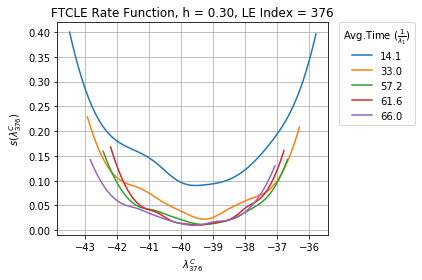


Working on plots for h = 0.53

Directory  ../Plots/Rate-Function-Convergence/h0_53  already exists


Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_1.png


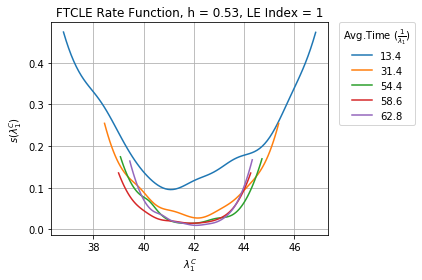

Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_2.png


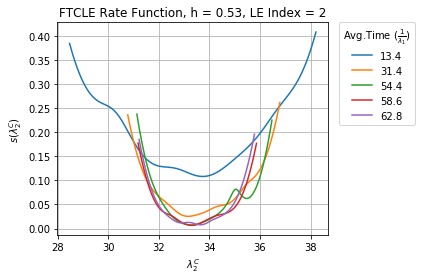

Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_3.png


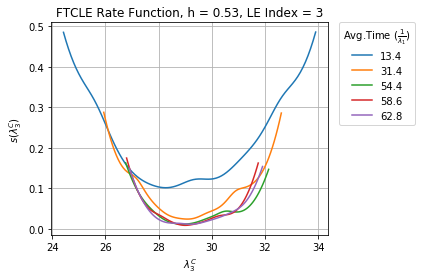

Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_182.png


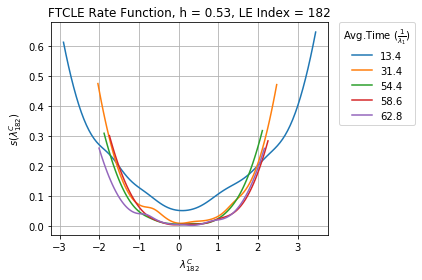

Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_183.png


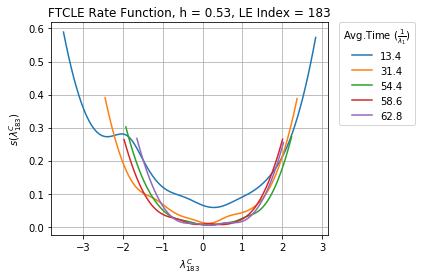

Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_184.png


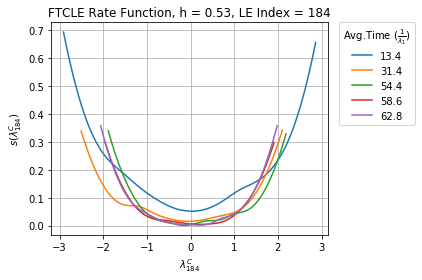

Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_374.png


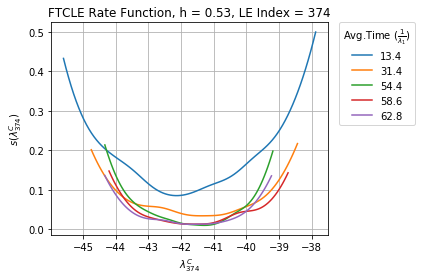

Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_375.png


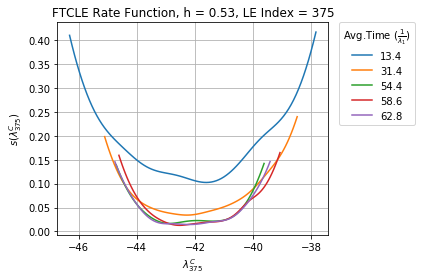

Will save at ../Plots/Rate-Function-Convergence/h0_53/LE_Index_376.png


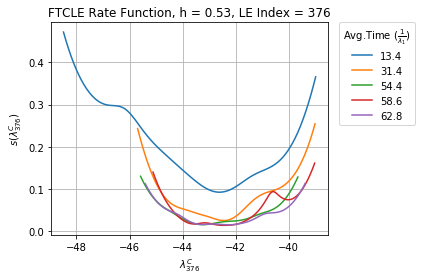


Working on plots for h = 0.77

Directory  ../Plots/Rate-Function-Convergence/h0_77  already exists


Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_1.png


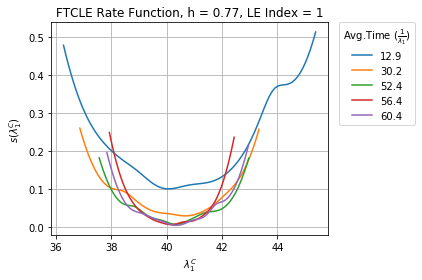

Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_2.png


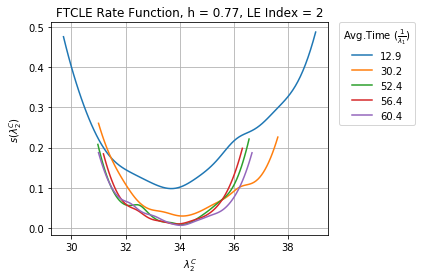

Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_3.png


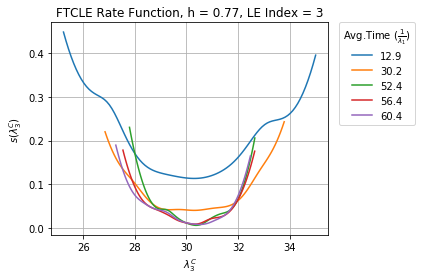

Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_177.png


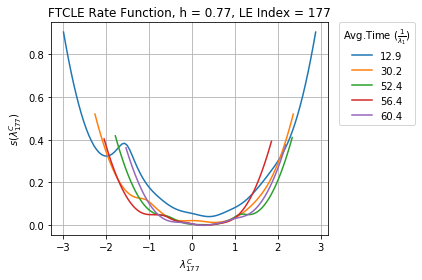

Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_178.png


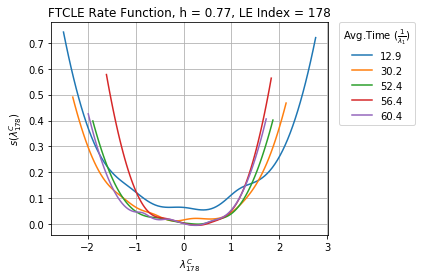

Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_179.png


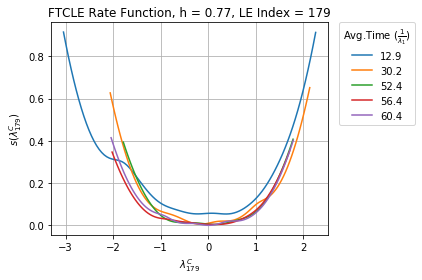

Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_374.png


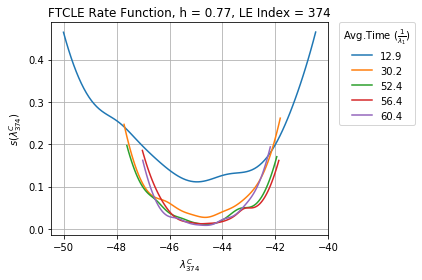

Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_375.png


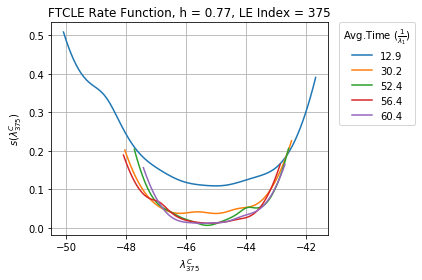

Will save at ../Plots/Rate-Function-Convergence/h0_77/LE_Index_376.png


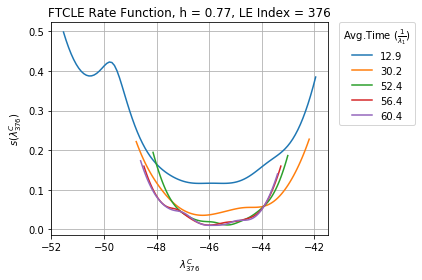


Working on plots for h = 1.00

Directory  ../Plots/Rate-Function-Convergence/h1_00  already exists


Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_1.png


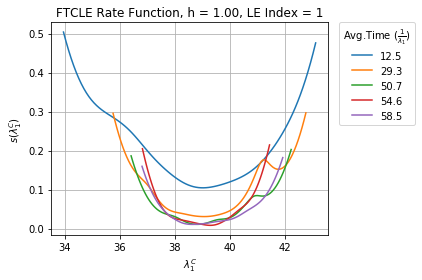

Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_2.png


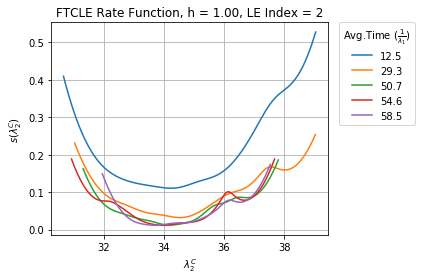

Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_3.png


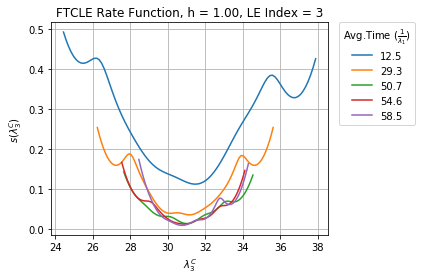

Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_171.png


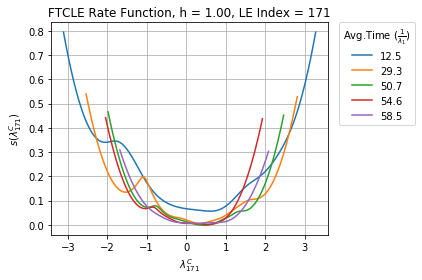

Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_172.png


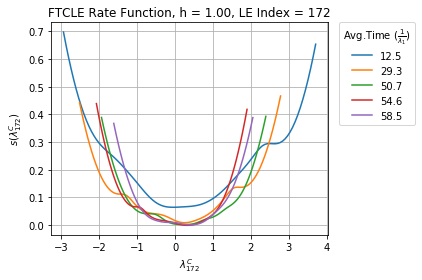

Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_173.png


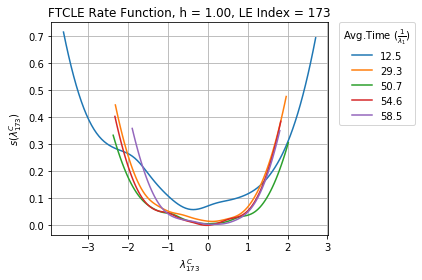

Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_374.png


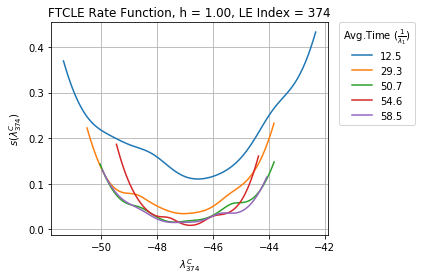

Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_375.png


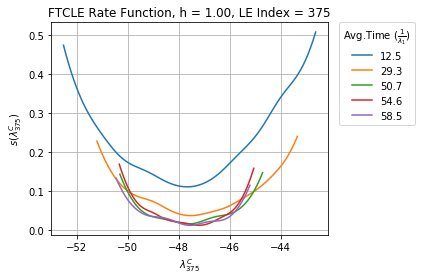

Will save at ../Plots/Rate-Function-Convergence/h1_00/LE_Index_376.png


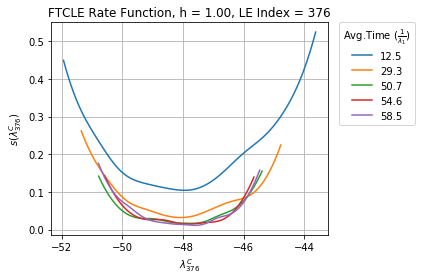

In [32]:
# FTCLE Rate Function Convergence

Ls = [32, 75, 130, 140, 150]  #Choices of averaging times
sample_size = 100

for i, data in enumerate(h_experiment):
    
    # Info we need from the data
    
    tau = data.tau
    h = data.h
    kd = data.k_d
    seconds = time_unit(data)
    print(f'Working on plots for h = {h:.2f}\n')
    
    # Save Directory
    
    dirName = '..' + f'/Plots/Rate-Function-Convergence/h{h:.2f}'.replace('.','_')
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")
    
    # Loop to plot for different indexes
    
    indexes = [1, 2, 3, kd - 1, kd, kd +1, 374, 375, 376]
    for index in tqdm(indexes):
        save = dirName + f'/LE_Index_{index}.png'
        print(f'Will save at {save}')
        
    # Loop to plot rate function for different averaging times
    
        for L in Ls:
            # Calculate FTCLEs and sample them randomly 
            ftle = ftcle_calculator(data.ftcle, L)
            FTLE = ftle.sel(le_index = index)
            samples = np.random.choice(FTLE, sample_size)
               
            # Kernel Density Estimation of Rate Function
            x_d = np.linspace(samples.min() - 1, samples.max() + 1, 100) # Grid we evaluate PDF on
            kde = gaussian_kde(samples) # KDE. Using Gaussian ker
            pdf = kde.evaluate(x_d)
            Ltau = L * tau * seconds # dimensionalised
            rate = - (np.log(pdf) / Ltau)
            
            plt.plot(x_d, rate, label = f'{Ltau:.1f}')
            
        # Plot Features     
        plt.title(f'FTCLE Rate Function, h = {data.h:.2f}, LE Index = {index}')
        #plt.xlim(FTLE.min() - 1, FTLE.max() + 1)
        plt.xlabel('$\\lambda_{' + f'{index}' + '}^C$')
        plt.ylabel('$s(\\lambda_{' + f'{index}' + '}^C$)')
        #plt.ylim(-1, rate.max() + 1)
        legend = plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
        legend.set_title('Avg.Time ($\\frac{1}{\\lambda_1}$)')
        plt.tight_layout()
        plt.savefig(save, dpi=1200)
        plt.grid()
        plt.show()
        
    

### KS Entropy Rate Function Con

In [ ]:
for i, data in enumerate(h_experiment):
    kd = data.k_d
    h = data.h
    tau = data.tau
    seconds = time_unit(data)

    for L in Ls:
        Ltau = L * tau * seconds
        L = L
        Ltau = L * tau
        ftle = ftcle_calculator(data.ftcle, L)
        ks = ks_entropy(ftle, data.k_d)
        x_d = np.linspace(ks.min() - 100, ks.max() + 100, 1000) # Grid we evaluate PDF on
        kde = gaussian_kde(ks) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
        pdf = kde.evaluate(x_d)
        rate = - (np.log(pdf) / Ltau)
        plt.plot(x_d, rate, label = f'{:.2f}, $k_d$ = {kd}')

plt.title(f'Effect of $h$ on KS Entropy Rate, Avg. Time = {Ltau}')
#plt.xlim(ks.min() - 100, ks.max() + 100)
plt.xlabel(f'$k_s$')
plt.ylabel(f'$s(k_s)$')
plt.ylim(rate.min() - 10, rate.max() + 10)
plt.legend(loc=8, mode="expand", ncol=2)
save = f'h-effect/Effect-of-Coupling-On-Rate/KS-Entropy.png'
plt.savefig(save, dpi=1200)
plt.show()

### Plotting Change in $KS$ entropy due to coupling 

In [ ]:
def ks_entropy(ftcle, kd):
    return ftle.isel(le_index = (ftle.le_index < kd)).sum('le_index')

In [ ]:
for i, data in enumerate(h_experiment):
    kd = data.k_d
    h = data.h
    tau = data.tau
    L = 150
    Ltau = L * tau
    ftle = ftcle_calculator(data.ftcle, L)
    ks = ks_entropy(data.ftcle, data.k_d)
    x_d = np.linspace(ks.min() - 100, ks.max() + 100, 1000) # Grid we evaluate PDF on
    kde = gaussian_kde(ks) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
    pdf = kde.evaluate(x_d)
    rate = - (np.log(pdf) / Ltau)
    plt.plot(x_d, rate, label = f'h= {h:.2f}, $k_d$ = {kd}')

plt.title(f'Effect of $h$ on KS Entropy Rate, Avg. Time = {Ltau}')
#plt.xlim(ks.min() - 100, ks.max() + 100)
plt.xlabel(f'$k_s$')
plt.ylabel(f'$s(k_s)$')
plt.ylim(rate.min() - 10, rate.max() + 10)
plt.legend(loc=8, mode="expand", ncol=2)
save = f'h-effect/Effect-of-Coupling-On-Rate/KS-Entropy.png'
plt.savefig(save, dpi=1200)
plt.show()

# Effect of Sample Size on Rate Function Convergence.

In [ ]:
Ls = [int(s) for s in np.linspace(5, 15, 5)]
sample_size = 1000

random_samples = False # True - random samples, False - evenly spaced

for i, data in enumerate(h_experiment):
    
    # Info we need from the data
    tau = data.tau
    h = data.h
    kd = data.k_d
    seconds = time_unit(data) # Inverse of first LE gives time unit
    
    print(f'Working on plots for h = {h:.2f}\n')
    
    # Save Directory
    dirName = f'h-effect/{i + 1}/Rate-Functions_h{h:.2f}'.replace('.','_')
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")
    
    # Looping of the LE_ indexes we want
    indexes = [1, 2, 3, kd - 2, kd - 1, kd, kd + 1, kd + 2, 394, 395, 396]
    for index in tqdm(indexes):
        save = dirName + f'/LE_Index_{index}.png'
        print(f'Will save at {save}')
        
    # Loop for different averaging times
        for L in Ls:
            Ltau = L * tau * seconds
            ftle = ftcle_calculator(data.ftcle, L)
            FTLE = ftle.sel(le_index = index)
            
            if (random_samples): 
                print('Random')
                samples = np.random.choice(FTLE, sample_size)
            else:
                print('Even')
                sample_step = int(FTLE.shape[0]/sample_size)
                samples = FTLE[::sample_step]
                print(samples.shape)
            
            x_d = np.linspace(samples.min() - 1, samples.max() + 1, 100) # Grid we evaluate PDF on
            kde = gaussian_kde(samples) # KDE. Using Gaussian ker
            
#             x_d = np.linspace(FTLE.min() - 1, FTLE.max() + 1, 100) # Grid we evaluate PDF on
#             kde = gaussian_kde(FTLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
            pdf = kde.evaluate(x_d)
            rate = - (np.log(pdf) / Ltau)
            plt.plot(x_d, rate, label = f'Avg. Time = {Ltau:.3f}' + '($\\frac{1}{\\lambda_1}$)')
        plt.title(f'Rate Function, h = {data.h:.2f}, LE Index = {index}')
        plt.xlim(FTLE.min() - 1, FTLE.max() + 1)
        plt.xlabel('$\\lambda_{' + f'{index}' + '}^C$')
        plt.ylabel('$s(\\lambda_{' + f'{index}' + '}^C$)')
        plt.ylim(-1, rate.max() + 1)
        plt.legend()
        #plt.yscale('log')
        #plt.savefig(save, dpi=1200)
        plt.show()

In [ ]:
# Calculating Angle Using BLVs

In [ ]:
data = h_experiment[0]

In [ ]:
unstable_manifold = data.BLV.isel(le_index=data.BLV.le_index <= data.k_d)
stable_manifold = data.BLV.isel(le_index=data.BLV.le_index > data.k_d)

In [ ]:
a = np.matmul(stable_manifold[0].T.values, unstable_manifold[0].values)

In [ ]:
np.arccos(np.linalg.svd(a)[1][np.linalg.svd(a)[1]<=1])

In [ ]:
def angle_calculator(data, sample_size):
    """ Calculates of minimum angle between stable and unstable manifolds.
    Randomly samples from data CLV time series
    """
    angles = []
    violators = [] # singular values greater than 1
    kd = data.k_d
    sample_indices = np.random.choice(data.CLV.time, sample_size)
    for CLV in tqdm(data.CLV.sel(time=sample_indices)):
        unstable_manifold = np.linalg.qr(CLV.isel(le_index=CLV.le_index <= kd))[0]
        stable_manifold = np.linalg.qr(CLV.isel(le_index=CLV.le_index > kd))[0]
        a = np.matmul(stable_manifold.T, unstable_manifold)
        singular_values = np.linalg.svd(a)[1]
        violators.append(singular_values[singular_values > 1])
        principal_angles = np.arccos(singular_values[singular_values<=1])
        angles.append(principal_angles)
    
    return angles, violators

In [ ]:
inputs = h_experiment
samples = 100
num_cores = multiprocessing.cpu_count()
print(f'{num_cores} cores available.\n')
print(f'Calculating angles for h = {data.h}\n')
print(f'kd = {data.k_d}')

angles, violators = Parallel(n_jobs=num_cores)(delayed(angle_calculator)(data, samples) for data in tqdm(inputs))

In [ ]:
samples = 100
min_angles = [] # List of lists. Each element is minimum angles for different h
for data in h_experiment:
    print(f'Calculating angles for h= {data.h:.2f}')
    angles = angle_calculator(data, samples)[0]
    min_angle = []
    for pa in angles:
        pa = pa[~np.isnan(pa)]
        min_angle.append(min(pa))
    min_angles.append(min_angle)
    

In [ ]:
min_angle = []
lengths = []
for pa in angles:
    pa = pa[~np.isnan(pa)]
    min_angle.append(min(pa))

In [ ]:
plt.plot([len(v) for v in violators])

In [ ]:
kd = data.k_d
CLV = data.CLV[0]
unstable_manifold = CLV.isel(le_index=CLV.le_index <= kd + 1)
stable_manifold = CLV.isel(le_index=CLV.le_index > kd)

In [ ]:
np.linalg.matrix_rank(unstable_manifold)

In [ ]:
np.linalg.matrix_rank(stable_manifold)

In [ ]:
np.arccos(180)

In [ ]:
ds1 = xr.open_dataset('ginelli/step2/BLV/BLV1.nc')
ds2 = xr.open_dataset('ginelli/step2/R/R1.nc')

In [ ]:
Q = ds1.BLV[0].values
R = ds2.R[0].values

In [ ]:
P = np.matmul(Q, R)